# **Retrieval**
- Step 1: PDF 문서 전처리 
- Step 2: Chroma로 VectorDB 구축하기
- Step 3: LangGraph로 LLM 답변 가져오기 

## **Step 1: PDF 문서 전처리**
### pdf 문서 전처리 과정: **pdf -> markdown -> txt** 
- 보통 사내 문서는 pdf가 많으나 그대로 로드해서 vector db에 넣기에는 문제가 있다. 
    - 줄바꿈시 한글 단어가 분리되어 깨짐   
    - 표 이미지를 문자열로 변환하지 못해서 표 이미지 데이터를 포함하지 못함
- 따라서 pdf를 markdown -> txt로 변환하여 사용해야함 
    - UnstructuredMarkdownLoader: 마크다운 파일을 로드해주는 라이브러리 
    - 이후 마크다운 테이블을 활용하기 위해서는 '.md' -> '.txt'로 변환하는 과정이 추가적으로 필요함

In [8]:
# uv add pypdf langchain-community langchain-text-splitters 
# uv add py-zerox nest_asyncio
# uv add "unstructured[md]" nltk

### 1-1. pdf 문서 로드
- PyPDFLoader로 pdf 문서 로드 
- page 단위로 Document 형식으로 변환해서 데이터 확인해보기 

In [ ]:
# uv add langchain-community
from langchain_community.document_loaders import PyPDFLoader

pdf_file_path = "../documents/income_tax.pdf"
loader = PyPDFLoader(pdf_file_path)

pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [12]:
pages[36]

Document(metadata={'producer': 'iText 2.1.7 by 1T3XT', 'creator': 'PyPDF', 'creationdate': '2026-02-05T20:35:46+09:00', 'moddate': '2026-02-05T20:35:46+09:00', 'source': '../documents/income_tax.pdf', 'total_pages': 137, 'page': 36, 'page_label': '37'}, page_content='법제처                                                            37                                                       국가법령정보센터\n소득세법\n하는 바에 따라 계산한 금액은 제1항에 따른 세액공제의 대상이 되는 외국소득세액으로 본다.<신설 2010. 12. 27.,\n2020. 12. 29.>\n⑤ 제1항부터 제4항까지의 규정에 따른 국외원천소득의 계산방법, 세액공제 또는 필요경비산입에 필요한 사항은\n대통령령으로 정한다.<개정 2010. 12. 27., 2013. 1. 1.>\n[전문개정 2009. 12. 31.]\n \n제57조의2(간접투자회사 등이 납부한 외국법인세액공제 특례) ① 거주자의 종합소득금액 또는 퇴직소득금액에 다음\n각 호의 요건을 갖춘 소득이 합산되어 있는 경우에는 제2항제2호에 따른 금액을 해당 과세기간의 종합소득산출세액\n에서 공제할 수 있다. <개정 2025. 12. 23.>\n1. 다음 각 목의 어느 하나에 해당하는 것(이하 이 조 및 제129조에서 “간접투자회사등”이라 한다)으로부터 지급받\n은 소득일 것\n가. 「자본시장과 금융투자업에 관한 법률」에 따른 투자회사, 투자목적회사, 투자유한회사, 투자합자회사(같은 법\n제9조제19항제1호의 기관전용 사모집합투자기구는 제외한다), 투자유한책임회사, 투자신탁, 투자합자조합 및\n투자익명조합\n나. 「부동산투자회사법」에

### 1-2. pdf -> markdown
- 파일 변환: `zerox`
- md 로드: `unstructured`

In [ ]:
# zerox 라이브러리를 통해 pdf 문서를 markdown 형식으로 변환해보기 
# uv add py-zerox 
from pyzerox import zerox
import asyncio
### 모델 설정 (Vision 모델만 사용) 참고: https://docs.litellm.ai/docs/providers ###

## 일부 모델에 필요할 수 있는 추가 모델 kwargs의 자리 표시자
kwargs = {}

## Vision 모델에 사용할 시스템 프롬프트
custom_system_prompt = None

model = "gpt-4o-mini" 

# 메인 비동기 진입점을 정의합니다
async def main():
    file_path = "../documents/income_tax.pdf" ## 로컬 파일 경로 및 파일 URL 지원

    ## 일부 페이지 또는 전체 페이지를 처리
    select_pages = None ## 전체는 None, 특정 페이지는 int 또는 list(int) 페이지 번호 (1부터 시작)

    output_dir = "../documents" ## 통합된 마크다운 파일을 저장할 디렉토리
    result = await zerox(file_path=file_path, model=model, output_dir=output_dir,
                        custom_system_prompt=custom_system_prompt, select_pages=select_pages, **kwargs)
    return result


# 메인 함수를 실행합니다:
result = asyncio.run(main())

# 마크다운 결과를 출력합니다
print(result)

In [ ]:
# 노트북에서 `asyncio`를 사용하기 위해 `nest_asyncio`를 설치해야 한다. 
# uv add nest_asyncio

import nest_asyncio
nest_asyncio.apply()

# Error converting PDF to images: Unable to get page count. Is poppler installed and in PATH?
# 위 오류가 발생하면 poppler를 설치해야 한다. 
# brew install poppler -> Jupyter에서 path 못찾는 경우 보정해주기 
import os
os.environ["PATH"] = "/opt/homebrew/bin:" + os.environ.get("PATH", "")

In [14]:
# uv add langchain-text-splitters
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 100,
    separators=['\n\n', '\n']
)

In [ ]:
# UnstructuredMarkdownLoader로 md 데이터 확인 
# uv add "unstructured[md]" nltk

from langchain_community.document_loaders import UnstructuredMarkdownLoader

markdown_path = "../documents/income_tax.md"
loader = UnstructuredMarkdownLoader(markdown_path)

# text_splitter 활용해 데이터 분할 
document_list = loader.load_and_split(text_splitter)

In [ ]:
document_list[43]

### 1-3. md -> txt 
- md -> txt 변환: `markdown` `html2text` `beautifulsoup4`
- txt 로드: `TextLoader`

In [19]:
#uv add markdown html2text beautifulsoup4

import markdown
from bs4 import BeautifulSoup

markdown_path = "../documents/income_tax.md"
text_path = '../documents/income_tax.txt'

# 마크다운 파일을 읽어옵니다
with open(markdown_path, 'r', encoding='utf-8') as md_file:
    md_content = md_file.read()

# 마크다운 콘텐츠를 HTML로 변환합니다
html_content = markdown.markdown(md_content)

# HTML 콘텐츠를 파싱하여 텍스트만 추출합니다
soup = BeautifulSoup(html_content, 'html.parser')
text_content = soup.get_text()

# 추출한 텍스트를 텍스트 파일로 저장합니다
with open(text_path, 'w', encoding='utf-8') as txt_file:
    txt_file.write(text_content)

print("Markdown converted to plain text successfully!")

Markdown converted to plain text successfully!


In [20]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader(text_path)
document_list = loader.load_and_split(text_splitter)

In [21]:
document_list[43]

Document(metadata={'source': '../documents/income_tax.txt'}, page_content='70세 이상인 사람(이하 "종로다자"라 한다)의 경우 1명당 연 100만원\n대통력으로 정하는 장애인(이하 "정애인"이라 한다)의 경우 1명당 연 200만원\n해당 거주자(해당 과세기간의 종합소득세표준을 계산할 때 거주자로 종합소득금액에 3만원 이하의 거주자로 한정한다)가 배우자가 없는 여성으로서 제50조제1항에 따른 부양가족이 있는 세대주이거나 배우자가 있는 여성인 경우 연 50만원\n삭제<2014. 1. 1.>\n삭제<2014. 1. 1.>\n해당 거주자가 배우자가 없는 사람으로서 기본공제대상자인 직계비속 또는 입양자가 있는 경우 연 100만원\n제항에 따른 공제는 "주거공제"라 한다.\n기본공제의 추가공제는 "입증공제"라 한다.<신설 2014. 1. 1.>\n인증공제의 합계액이 종합소득금액을 초과하는 경우 그 초과하는 공제액은 없는 것으로 한다.<신설 2014. 1. 1.>\n\n제51조의4(주택담보노후얼림 이자비용공제)\n\n연금소득이 있는 거주자가 대통력으로 정하는 요건에 해당하는 주택담보노후얼림을 받는 연금이 이에 해당 연금의 해제기간이 발생한 이자비용상당액과 그 세게리과세기간에 신고한 경우(이하 "주택담보노후얼림 이자비용공제"라 한다)인 경우 공제액이 이자 상한액의 200만원을 초과하는 경우에는 그 금액을 공제하고, 연금소득금액을 초과하는 경우 그 초과액은 없는 것으로 한다.\n주택담보노후얼림 이자비용공제는 해당 거주자 각신에 적용한다.\n삭제<2014. 1. 1.>\n제52조의2는 특별소득세제\n조세특례제한법에 따른 소득세제\n\n제52조(복식부기)\n\n근로소득이 있는 거주자(입양근로자로는 제외한다. 이하 이 조에서 같든과세기간에 「국민건강보험법」、「고용보험법」 또는 「노인장기요양보험법」에 따라 근로자가 부담하는 보험료를 지급한 경우 그\n\n금액을 해달 과세기간의 근로소득금액에서 공제한다. <개정 2014. 1

## **Step 2: Chroma로 VectorDB 구축하기**
- 전처리된 데이터를 벡터화하기 위해 [Chroma](https://docs.trychroma.com/getting-started)를 활용합니다
- LangChain과의 호환을 위해 [langchain-chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma/)를 설치합니다

In [ ]:
# uv add langchain-chroma langchain-openai

In [22]:
from dotenv import load_dotenv

load_dotenv()

True

In [23]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

In [ ]:
from langchain_chroma import Chroma

vector_store = Chroma.from_documents(
    documents=document_list, #위에서 전처리된 txt 데이터 
    embedding=embeddings,
    collection_name = 'income_tax_collection',
    persist_directory = '../income_tax_collection' #로컬에 영구 저장 버전 
)

In [ ]:
# retriever 생성
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

# vector db 검색 test 
result = retriever.invoke('연봉 5천만원 직장인의 소득세는?')
print(result)

## **Step 3: LangGraph로 LLM 답변 가져오기**
- state, node 정의 -> stateGraph 생성 -> 노드 연결 -> 그래프 생성 -> 실행 

In [31]:
# State 정의 
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [32]:
# Node 정의 
from langchain_core.prompts import ChatPromptTemplate

def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    
    docs = retriever.invoke(query)

    return {'context': docs}

In [33]:
from langchain_openai import ChatOpenAI
from langsmith import Client

llm = ChatOpenAI(model='gpt-4o-mini')
client = Client()

In [34]:
def generate(state: AgentState) -> AgentState:
    context = state['context']
    query = state['query']
    
    prompt = client.pull_prompt("rlm/rag-prompt")
    rag_chain = prompt | llm
    response = rag_chain.invoke({'question': query, 'context': context})

    return {'answer': response.content}

In [35]:
# stateGraph 생성
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

In [36]:
# Node, Edge 연결 
from langgraph.graph import START, END

graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_edge('retrieve', 'generate')
graph_builder.add_edge('generate', END)

In [37]:
# 그래프 생성 
graph = graph_builder.compile()

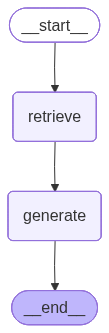

In [38]:
# 그래프 시각화 
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

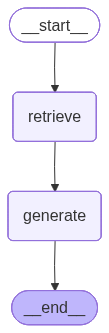

In [39]:
# 병렬처리나 `conditional_edge`가 없는 경우 `add_sequence()`를 통해 순차적으로 동작하는 그래프를 생성할 수 있습니다

#graph_builder = StateGraph(AgentState)
#graph_builder.add_node('retrieve', retrieve)
#graph_builder.add_node('generate', generate)
# -> 아래 코드로 한번에 가능, 함수명 그대로 노드명 사용 
sequence_graph_builder = StateGraph(AgentState).add_sequence([retrieve, generate])

sequence_graph_builder.add_edge(START, 'retrieve')
sequence_graph_builder.add_edge('generate', END)

sequence_graph = sequence_graph_builder.compile()

display(Image(sequence_graph.get_graph().draw_mermaid_png()))

In [44]:
# 그래프 실행 
query = '연봉 5천만원 직장인의 소득세는 얼마입니까?'
initial_state = {'query': query}
graph.invoke(initial_state)

{'query': '연봉 5천만원 직장인의 소득세는 얼마입니까?',
 'context': [Document(id='587bb229-bf18-4b44-b8e0-5225e00aeaad', metadata={'source': '../documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
  Document(id='2ef7c442-cccb-4aaf-9813-f5617b7966e7', metadata={'source': '../documents/income_tax.txt'}, page_content='이자소득에 대